In [1]:
import thermopyl as th
from thermopyl import thermoml_lib
import cirpy
import numpy as np
import pandas as pd

import functools
from functools import reduce
from os.path import expanduser
from joblib import Memory

"""
Получить мольные доли компонентов и давление. CO2 и n-Decan. CO2 обычно идет вторым.
Построить зависимость мольного соотношения от давления.
"""

'\nПолучить мольные доли компонентов и давление. CO2 и n-Decan. CO2 обычно идет вторым.\nПостроить зависимость мольного соотношения от давления.\n'

In [3]:
home = expanduser("~")
desired_components = ['carbon dioxide', 'n-dodecane']
df = th.pandas_dataframe()
mem = Memory(location=home+"/.thermoml/")

@mem.cache
def resolve_cached(x, rtype):
   return cirpy.resolve(x, rtype)
    
# experiments=['Mole fraction']
# ind_list = [df[exp].dropna().index for exp in experiments]
# ind = reduce(lambda x, y: x.union(y), ind_list)


name_to_formula = pd.read_parquet("~/.thermoml/compound_name_to_formula.pq").dropna()
# ind_list
# ind
# name_to_formula

def feature_occurency(df, feature):
    dt = list(df.columns)
    col_list = [colname for colname in dt if feature in colname]
    print(f'Dataframe size: {len(df)}')
    for substring in col_list:
        print(f'Number of "{substring}" entries: {len(df)-df[substring].isnull().sum()}')
        
feature_occurency(df, 'Mole fraction')

Dataframe size: 382763
Number of "Mole fraction" entries: 348552
Number of "Mole fraction_std" entries: 0
Number of "Solvent: Mole fraction" entries: 37498
Number of "Mole fraction Variable metadata" entries: 188076
Number of "Mole fraction metadata" entries: 2707


In [4]:
desired_components = ['InChI=1S/CO2/c2-1-3', 'InChI=1S/C10H22/c1-3-5-7-9-10-8-6-4-2/h3-10H2,1-2H3']
# filtered = df[df['components'].str.contains('carbon dioxide')]
# print(len(filtered), filtered['Mole fraction'].isnull().sum())

# filtered = filtered[['components'].str.contains('carbon dioxide')]

df['n_components'] = df.components.apply(
    lambda x: len(x.split('__'))
)
# df_binary = df[df.n_components == 2]
df_binary = df.copy()
print(len(df_binary))

df_my_1 = df_binary[df_binary.component_1_inchi == 'InChI=1S/CO2/c2-1-3']
df_my_1 = df_my_1[df_my_1.component_2_inchi == 'InChI=1S/C10H22/c1-3-5-7-9-10-8-6-4-2/h3-10H2,1-2H3']
df_my_2 = df_binary[df_binary.component_2_inchi == 'InChI=1S/CO2/c2-1-3']
df_my_2 = df_my_2[df_my_2.component_1_inchi == 'InChI=1S/C10H22/c1-3-5-7-9-10-8-6-4-2/h3-10H2,1-2H3']
# df_mycomponents = df_binary[df_binary.component_2_inchi == 'InChI=1S/CO2/c2-1-3']
# df_mycomponents = df_mycomponents[df_mycomponents.component_1_inchi == 'InChI=1S/C10H22/c1-3-5-7-9-10-8-6-4-2/h3-10H2,1-2H3']
print(len(df_my_1))
print(len(df_my_2))
df_merged = pd.concat([df_my_1, df_my_2])
print(len(df_merged))
# df_mycomponents = df_mycomponents[df_mycomponents.component_1_inchi == 'InChI=1S/C10H22/c1-3-5-7-9-10-8-6-4-2/h3-10H2,1-2H3']

382763
0
243
243


In [11]:
feature_occurency(df_merged, 'Mole fraction')
feature_occurency(df_merged, 'Pressure')
feature_occurency(df_merged, 'Temperature')

Dataframe size: 243
Number of "Mole fraction" entries: 243
Number of "Mole fraction_std" entries: 0
Number of "Solvent: Mole fraction" entries: 54
Number of "Mole fraction Variable metadata" entries: 211
Number of "Mole fraction metadata" entries: 2
Dataframe size: 243
Number of "Pressure, kPa" entries: 145
Dataframe size: 243
Number of "Temperature, K" entries: 242


In [12]:
def filter_dataframe(df: pd.DataFrame, *keywords: str) -> pd.DataFrame:
    # Create a copy of the dataframe to avoid modifying the original one
    df_filtered = df.copy()
    
    # Iterate over each keyword
    for keyword in keywords:
        # Check if the keyword is a column in the dataframe
        if keyword in df.columns:
            # Filter rows where the column value is not None
            df_filtered = df_filtered[df_filtered[keyword].notna()]
    
    return df_filtered

main_features = ["Mole fraction", "Pressure, kPa", "Temperature, K"]
df_filtered = filter_dataframe(df_merged, *main_features)
print(len(df_filtered))

145


In [13]:
# print(*list(df_filtered.columns), sep="\n")
# print(df_filtered.filename.nunique())
for feature in main_features + ['filename']:
    print(f'Number of different "{feature}": {df_filtered[feature].nunique()}')

Number of different "Mole fraction": 32
Number of different "Pressure, kPa": 36
Number of different "Temperature, K": 1
Number of different "filename": 1


In [14]:
print(df_filtered['filename'].iloc[-1])
print(df_filtered['Temperature, K'].iloc[-1])
for entry in df_filtered.iloc:
    if entry.n_components == 3:
        print(entry.components)
        # for some in entry:
        #     print(some)
        break


./mixture_data/j.fluid.2012.09.037.xml
373.2
decane__carbon dioxide__tetradecane


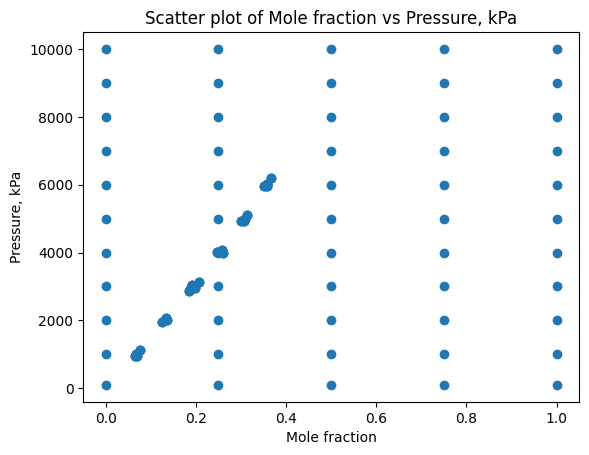

In [15]:
import matplotlib.pyplot as plt

f_comp = 'Mole fraction'
s_comp = 'Pressure, kPa'
# Assuming df is your DataFrame and 'column1' and 'column2' are the names of your columns
plt.scatter(df_filtered[f_comp], df_filtered[s_comp])
plt.xlabel(f_comp)
plt.ylabel(s_comp)
plt.title(f'Scatter plot of {f_comp} vs {s_comp}')

plt.show()